In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Function
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, balanced_accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch, gc

device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_src_train = np.load('data_src_norm/X_src_train.npy')
y_src_train = np.load('data_src_norm/y_src_train.npy')
X_src_val = np.load('data_src_norm/X_src_test.npy')      
y_src_val = np.load('data_src_norm/y_src_test.npy')     
X_t_train = np.load('data_tgt_norm/X_tgt_train.npy')
y_t_train = np.load('data_tgt_norm/y_tgt_train.npy')
X_t_test = np.load('data_tgt_norm/X_tgt_test.npy')
y_t_test = np.load('data_tgt_norm/y_tgt_test.npy')

def flat_to_cnn_shape(X_flat, T=2000, C=3, order='F'):
    X = X_flat.reshape(len(X_flat), T, C, order=order)  
    return np.transpose(X, (0, 2, 1))                   

X_src_train_cnn = flat_to_cnn_shape(X_src_train, T=2000, C=3, order='F')
X_src_val_cnn   = flat_to_cnn_shape(X_src_val,   T=2000, C=3, order='F')  
X_t_train_cnn   = flat_to_cnn_shape(X_t_train,   T=2000, C=3, order='F')
X_t_test_cnn    = flat_to_cnn_shape(X_t_test,    T=2000, C=3, order='F')

print("CNN data shapes:")
print(f"X_src_train_cnn: {X_src_train_cnn.shape}") 
print(f"X_t_train_cnn: {X_t_train_cnn.shape}")

def make_loader_cnn(X, y=None, batch_size=64, shuffle=True):
    X_tensor = torch.from_numpy(np.array(X)).float()
    if y is not None:
        y_tensor = torch.from_numpy(np.array(y)).float().unsqueeze(1)
        ds = TensorDataset(X_tensor, y_tensor)
    else:
        ds = TensorDataset(X_tensor)
    return DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=shuffle)

BATCH_SIZE = 256
src_loader = make_loader_cnn(X_src_train_cnn, y_src_train, BATCH_SIZE)
tgt_loader = make_loader_cnn(X_t_train_cnn, None, BATCH_SIZE)
val_loader = make_loader_cnn(X_src_val_cnn, y_src_val, BATCH_SIZE)

Using device: mps
CNN data shapes:
X_src_train_cnn: (93840, 3, 2000)
X_t_train_cnn: (93840, 3, 2000)


In [4]:
# МОДЕЛЬ
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)  
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReversalLayer(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)
    
    def set_alpha(self, alpha):
        self.alpha = alpha

class CNN1DEncoder(nn.Module):
    def __init__(self, in_ch=3, emb_dim=128, dropout=0.2):
        super().__init__()
        self.fe = nn.Sequential(
            nn.Conv1d(in_ch, 32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),     

            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),     
            nn.Dropout(dropout),

            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),     
            nn.Dropout(dropout),

            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),     
        )
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.proj = nn.Linear(128, emb_dim)

    def forward(self, x_bcT):
        h = self.fe(x_bcT)              
        h = self.gap(h).squeeze(-1)     
        z = self.proj(h)                
        return z

class TaskClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 16), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(16, 1)  
        )
    def forward(self, x): 
        return self.net(x)

class DomainDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 1) 
        )
    def forward(self, features):
        return self.net(features)

class DANN(nn.Module):
    def __init__(self, in_ch=3, emb_dim=128):  
        super().__init__()
        self.feature_extractor = CNN1DEncoder(in_ch=in_ch, emb_dim=emb_dim)
        self.label_predictor = TaskClassifier()
        self.domain_classifier = DomainDiscriminator()
        self.grl = GradientReversalLayer()
        
    def forward(self, x):  
        features = self.feature_extractor(x)
        label_pred = self.label_predictor(features)
        reversed_features = self.grl(features)
        domain_pred = self.domain_classifier(reversed_features)
        return label_pred, domain_pred

    def predict_proba(self, X_cnn, batch_size=64):
        self.eval()
        X_tensor = torch.from_numpy(np.array(X_cnn)).float()
        if X_tensor.ndim != 3:
            raise ValueError("Ожидается [N, C, T] формат")
        preds = []
        with torch.no_grad():
            for i in range(0, len(X_tensor), batch_size):
                x_batch = X_tensor[i:i+batch_size].to(device)
                label_pred, _ = self(x_batch)
                preds.append(torch.sigmoid(label_pred).cpu().numpy().flatten())
        return np.concatenate(preds, 0)

In [5]:
# УТИЛИТЫ
def accuracy_from_logits(logits, labels):
    preds = (torch.sigmoid(logits) > 0.5).float()
    return (preds == labels).sum().item() / len(labels)

def find_best_threshold_f1_macro(y_true, y_proba):
    #Подбирает лучший порог по F1 Macro
    best_thresh, best_f1_macro = 0.5, 0
    for thresh in np.arange(0.1, 0.9, 0.05):
        y_pred = (y_proba > thresh).astype(int)
        f1_macro = f1_score(y_true, y_pred, average='macro')
        if f1_macro > best_f1_macro:
            best_f1_macro, best_thresh = f1_macro, thresh
    return best_thresh, best_f1_macro

def calculate_all_metrics(y_true, y_proba, threshold):
    #Считает все метрики для заданного порога
    y_pred = (y_proba > threshold).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_binary': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba)
    }
    return metrics

def logits_by_batches(model, X, device, batch_size=256):
    model.eval()
    X_np = np.array(X)                 
    all_logits = []
    with torch.no_grad():
        for i in range(0, len(X_np), batch_size):
            xb = torch.from_numpy(X_np[i:i+batch_size]).float().to(device, non_blocking=True)
            logits, _ = model(xb)      
            all_logits.append(logits.cpu())
            del xb, logits
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()
        gc.collect()
        if torch.backends.mps.is_available():
            torch.mps.empty_cache()
    return torch.cat(all_logits, dim=0).numpy().flatten()

In [6]:
# ================== ВИЗУАЛИЗАЦИЯ ==================
def visualize_probabilities_boxplot(model, X_src_val, y_src_val, X_t_test, y_t_test,
                                   device, batch_size=256, sample_size=5000, seed=42):
    """Boxplot по вероятностям (вместо логитов)"""
    np.random.seed(seed)
    
    idx_s = np.random.choice(len(X_src_val), min(sample_size, len(X_src_val)), replace=False)
    idx_t = np.random.choice(len(X_t_test), min(sample_size, len(X_t_test)), replace=False)

    src_logits = logits_by_batches(model, X_src_val[idx_s], device, batch_size)
    tgt_logits = logits_by_batches(model, X_t_test[idx_t], device, batch_size)
    
    # Преобразуем логиты в вероятности
    src_probs = 1 / (1 + np.exp(-src_logits))  # sigmoid
    tgt_probs = 1 / (1 + np.exp(-tgt_logits))

    y_src_sub = y_src_val[idx_s]
    y_tgt_sub = y_t_test[idx_t]

    src_normal  = src_probs[y_src_sub == 0]
    src_anomaly = src_probs[y_src_sub == 1]
    tgt_normal  = tgt_probs[y_tgt_sub == 0]
    tgt_anomaly = tgt_probs[y_tgt_sub == 1]

    plt.figure(figsize=(8,6))
    plt.boxplot([src_normal, src_anomaly, tgt_normal, tgt_anomaly],
                labels=['Source\nNormal','Source\nAnomaly','Target\nNormal','Target\nAnomaly'])
    plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold 0.5')
    plt.ylabel('Probability')
    plt.title('Domain Shift: Probabilities Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_four_confusion_matrices(model, datasets, threshold, title_suffix=""):
    # 4 confusion matrix с одним порогом
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for i, (X, y, title) in enumerate(datasets):
        y_proba = model.predict_proba(X, batch_size=64)
        y_pred = (y_proba > threshold).astype(int)
        
        cm = confusion_matrix(y, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues',
                   xticklabels=['Pred Normal','Pred Anomaly'],
                   yticklabels=['True Normal','True Anomaly'])
        axes[i].set_title(f'{title} {title_suffix}')
    
    plt.suptitle(f'Confusion Matrices (threshold={threshold:.3f})')
    plt.tight_layout()
    plt.show()

def plot_four_roc_curves(model, datasets):
    """Строит 4 ROC кривые"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for i, (X, y, title) in enumerate(datasets):
        y_proba = model.predict_proba(X, batch_size=64)
        fpr, tpr, _ = roc_curve(y, y_proba)
        auc_score = auc(fpr, tpr)
        
        axes[i].plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
        axes[i].plot([0,1], [0,1], 'k--', alpha=0.5)
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].set_title(f'{title}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('ROC Curves')
    plt.tight_layout()
    plt.show()

def plot_training_curves(history):
    """Графики динамики обучения"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1) Losses
    axes[0].plot(history['loss'], label='Label Loss', linewidth=2)
    axes[0].plot(history['disc_loss'], label='Domain Loss', linewidth=2)
    axes[0].set_title('Losses During Training')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2) Accuracy & F1
    axes[1].plot(history['accuracy'], label='Source Accuracy', linewidth=2)
    axes[1].plot(history['val_f1'], label='Val F1 Macro', linewidth=2)
    if 'target_auc' in history:
        axes[1].plot(history['target_auc'], label='Target AUC', linestyle='--', linewidth=2)
    axes[1].set_title('Accuracy & F1 During Training')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3) Domain Classifier Accuracy
    axes[2].plot(history['disc_acc'], label='Domain Accuracy', linewidth=2)
    axes[2].axhline(y=0.5, color='red', linestyle='--', label='Target (0.5)', linewidth=2)
    axes[2].set_title('Domain Classifier Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



==================== Тестируем λ = 0.15 ====================
Epoch 1/30 - loss: 0.3874 - accuracy: 0.8117 - disc_loss: 0.6864 - disc_acc: 0.5408 - val_f1_macro: 0.5982 - target_auc: 0.8041 - λ: 0.1500
Epoch 2/30 - loss: 0.2391 - accuracy: 0.8990 - disc_loss: 0.6792 - disc_acc: 0.5682 - val_f1_macro: 0.6145 - target_auc: 0.7691 - λ: 0.1500
Epoch 3/30 - loss: 0.1991 - accuracy: 0.9164 - disc_loss: 0.6756 - disc_acc: 0.5788 - val_f1_macro: 0.4131 - target_auc: 0.8576 - λ: 0.1500
Epoch 4/30 - loss: 0.1785 - accuracy: 0.9240 - disc_loss: 0.6726 - disc_acc: 0.5854 - val_f1_macro: 0.6962 - target_auc: 0.7676 - λ: 0.1500
Epoch 5/30 - loss: 0.1704 - accuracy: 0.9270 - disc_loss: 0.6720 - disc_acc: 0.5876 - val_f1_macro: 0.6049 - target_auc: 0.7580 - λ: 0.1500
Epoch 6/30 - loss: 0.1623 - accuracy: 0.9317 - disc_loss: 0.6705 - disc_acc: 0.5938 - val_f1_macro: 0.4981 - target_auc: 0.8650 - λ: 0.1500
Epoch 7/30 - loss: 0.1520 - accuracy: 0.9368 - disc_loss: 0.6702 - disc_acc: 0.5940 - val_f1_macro

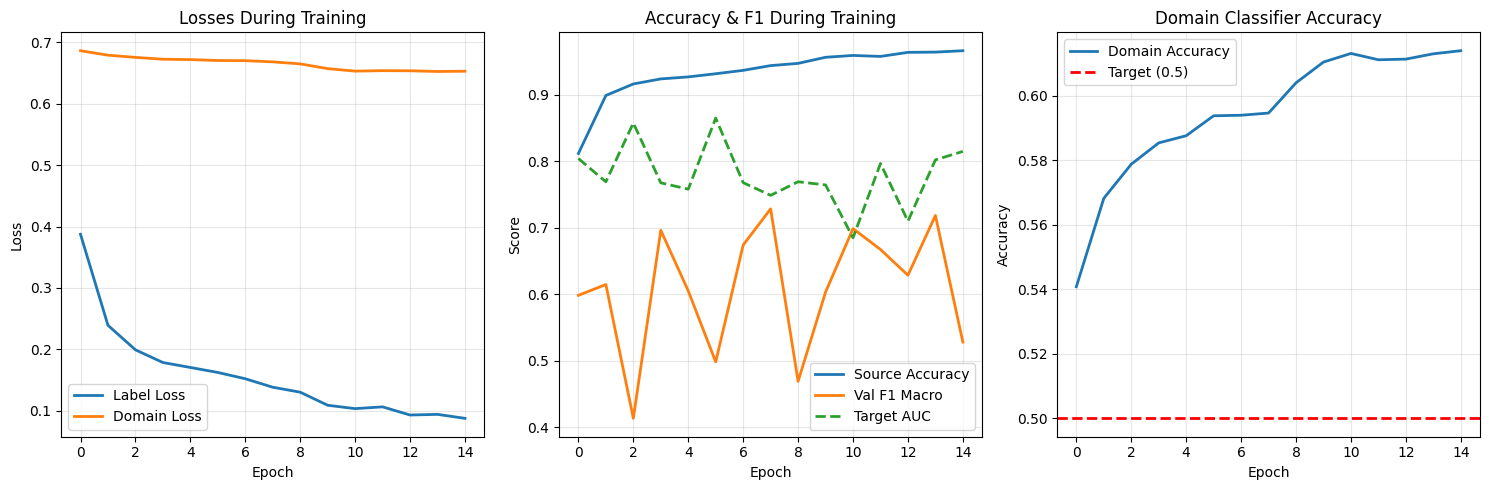


ПОЛНЫЙ ОТЧЁТ ДЛЯ λ = 0.15
Best Threshold (по F1 Macro на source val): 0.1000

                  МЕТРИКИ ДЛЯ ВСЕХ НАБОРОВ                  
------------------------------------------------------------
Dataset         Acc      Bal_Acc  F1_Macro  F1_Bin   Prec     Recall   AUC     
------------------------------------------------------------
Source Train    0.550    0.542    0.530     0.432    0.546    0.357     0.736
Source Test     0.549    0.541    0.528     0.427    0.545    0.352     0.738
Target Train    0.743    0.745    0.743     0.744    0.710    0.782     0.815
Target Test     0.743    0.744    0.743     0.742    0.713    0.775     0.815

CONFUSION MATRICES


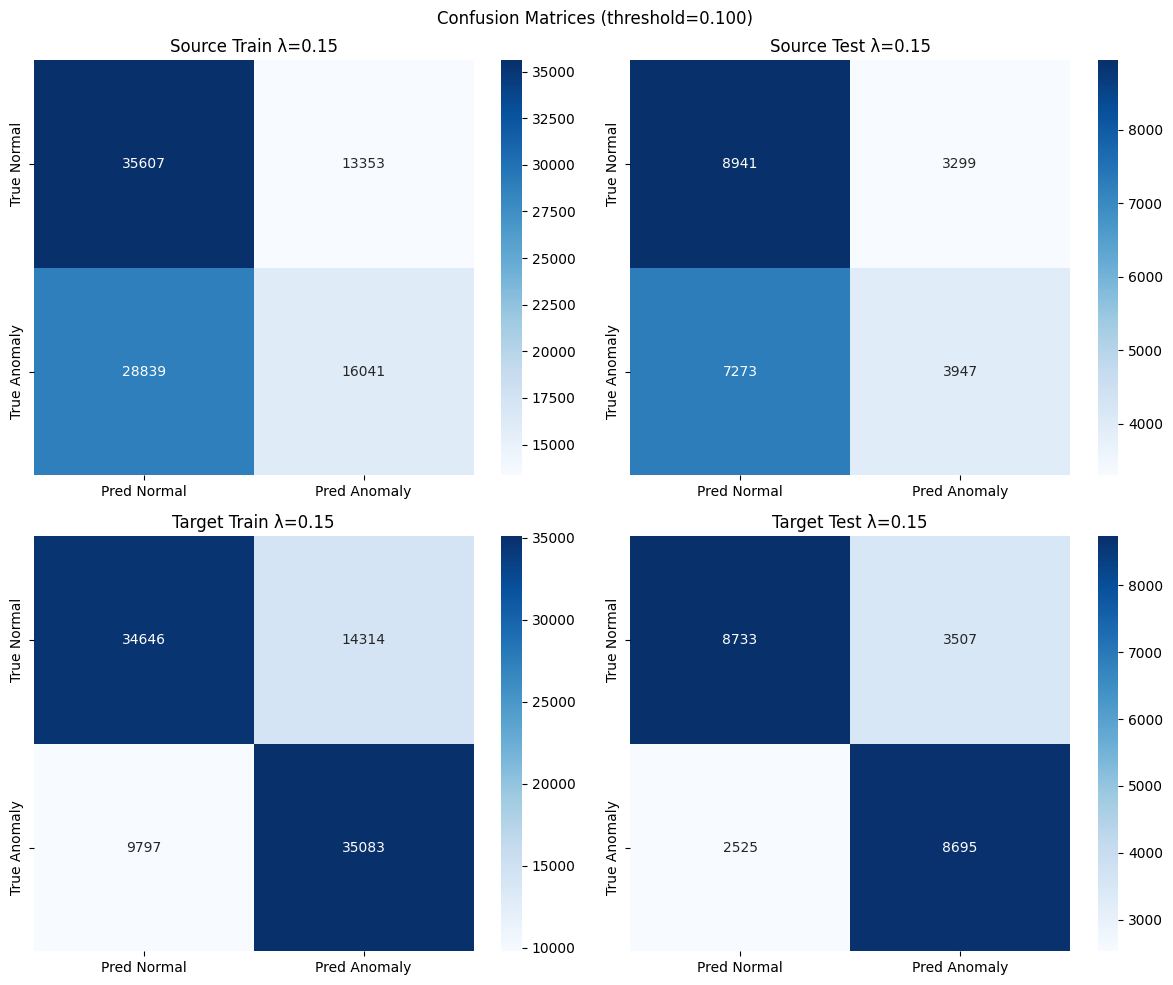


ROC CURVES


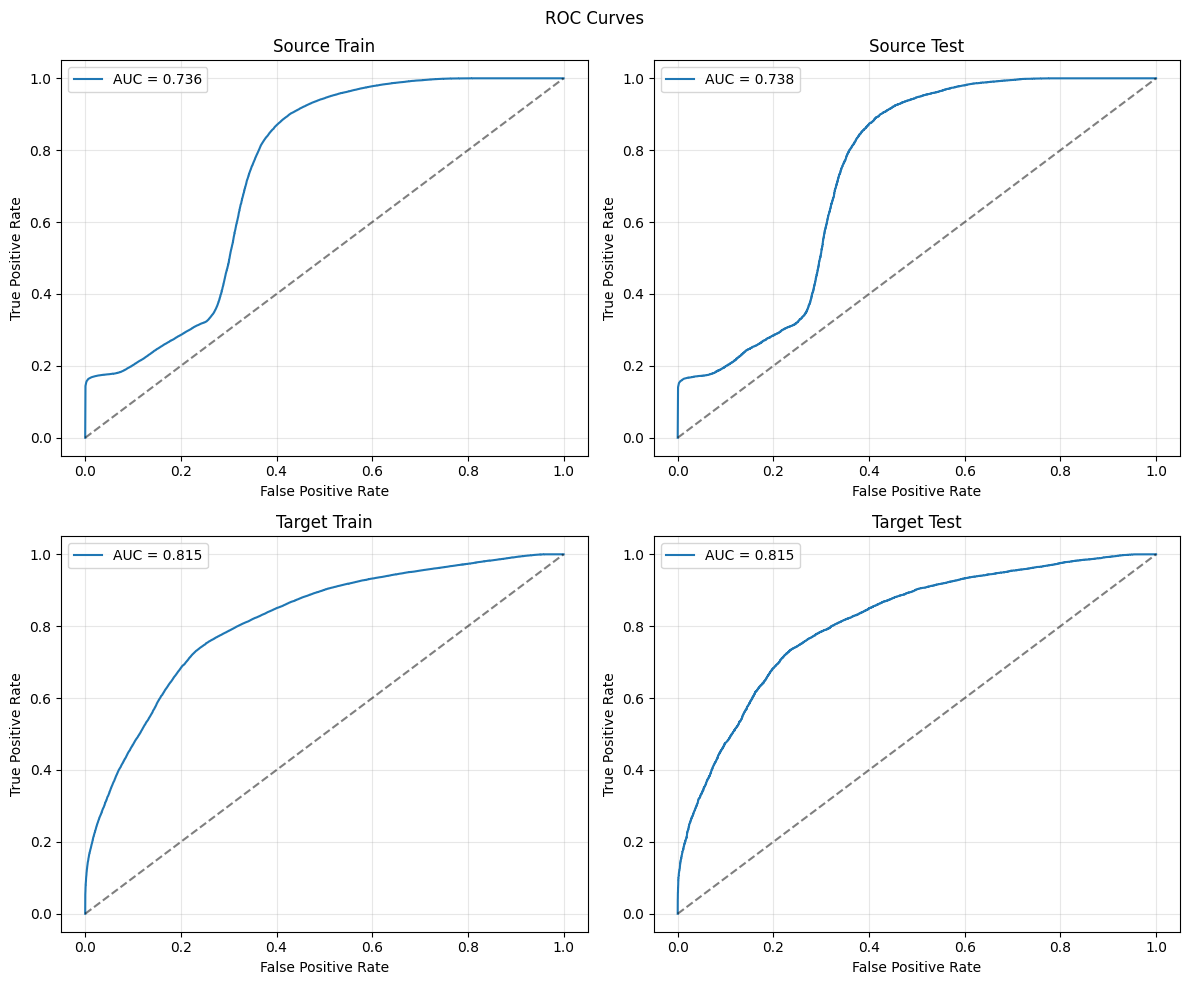


PROBABILITIES DISTRIBUTION


/var/folders/t3/4qj_4k256mxg4l2py__407l00000gn/T/ipykernel_9245/458173156.py:15: RuntimeWarning: overflow encountered in exp
  tgt_probs = 1 / (1 + np.exp(-tgt_logits))
/var/folders/t3/4qj_4k256mxg4l2py__407l00000gn/T/ipykernel_9245/458173156.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([src_normal, src_anomaly, tgt_normal, tgt_anomaly],


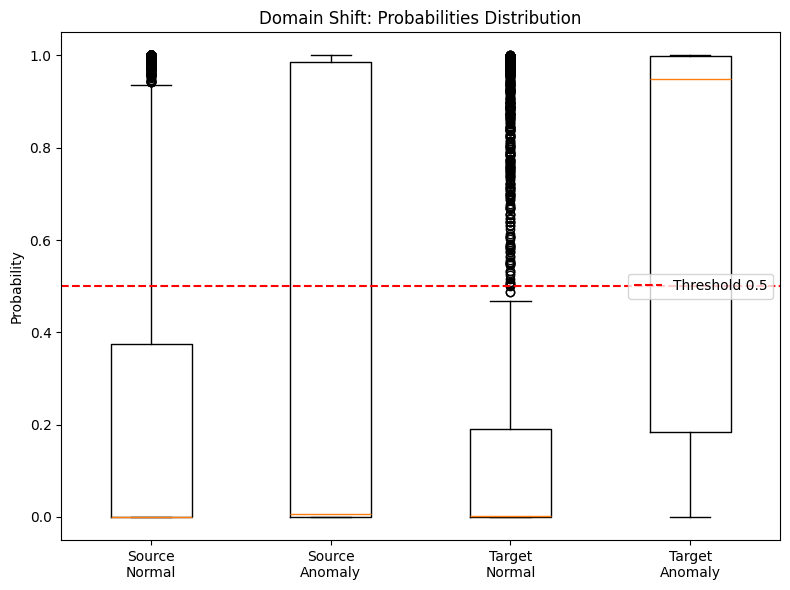


ИТОГОВОЕ СРАВНЕНИЕ λ
λ      Threshold  Target_Acc  Target_F1M   Target_AUC  Disc_Acc 
------------------------------------------------------------
0.15   0.100      0.743       0.743        0.815       0.614    
Лучший результат по F1 Macro: λ = 0.15
F1 Macro на target: 0.743
Accuracy на target: 0.743


In [5]:
# ОБУЧЕНИЕ
def train_dann_with_target_tracking(model, src_loader, tgt_loader, val_loader, X_val_cnn, y_val,
                                   X_target_cnn, y_target,
                                   epochs=50, lr=1e-4, early_stopping=10, lambda_const=0.15):
    # Обучение с отслеживанием метрик на target
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion_label = nn.BCEWithLogitsLoss()
    criterion_domain = nn.BCEWithLogitsLoss()
    
    best_val_f1, patience = 0, 0
    best_state = None

    history = {
        "loss": [], "accuracy": [], "disc_loss": [], "disc_acc": [],
        "val_f1": [], "target_auc": [], "target_f1_macro": [], "λ": []
    }

    for epoch in range(epochs):
        model.train()
        λ = lambda_const
        model.grl.set_alpha(λ)
        
        epoch_losses, epoch_accs = [], []
        epoch_disc_losses, epoch_disc_accs = [], []
        
        min_len = min(len(src_loader), len(tgt_loader))
        src_iter, tgt_iter = iter(src_loader), iter(tgt_loader)
        
        for batch_idx in range(min_len):
            try:
                src_data, src_labels = next(src_iter)
                tgt_data = next(tgt_iter)[0]
            except StopIteration:
                break
                
            batch_size = min(src_data.size(0), tgt_data.size(0))
            src_data = src_data[:batch_size].to(device)
            src_labels = src_labels[:batch_size].to(device)
            tgt_data = tgt_data[:batch_size].to(device)
            
            optimizer.zero_grad()
            
            src_label_pred, src_domain_pred = model(src_data)
            _, tgt_domain_pred = model(tgt_data)
            
            loss_label = criterion_label(src_label_pred, src_labels)
            
            domain_labels = torch.cat([
                torch.zeros(batch_size, 1, device=device),
                torch.ones(batch_size, 1, device=device)
            ])
            
            domain_preds = torch.cat([src_domain_pred, tgt_domain_pred])
            loss_domain = criterion_domain(domain_preds, domain_labels)
            
            total_loss = loss_label + λ * loss_domain
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            label_acc = accuracy_from_logits(src_label_pred, src_labels)
            domain_acc = accuracy_from_logits(domain_preds, domain_labels)
            
            epoch_losses.append(loss_label.item())
            epoch_accs.append(label_acc)
            epoch_disc_losses.append(loss_domain.item())
            epoch_disc_accs.append(domain_acc)
        
        # Валидация на source
        model.eval()
        val_proba = model.predict_proba(X_val_cnn)         
        best_thresh, val_f1_macro = find_best_threshold_f1_macro(y_val, val_proba)  
        
        # Отслеживание target метрик 
        target_proba = model.predict_proba(X_target_cnn)
        target_auc = roc_auc_score(y_target, target_proba)
        target_f1_macro = f1_score(y_target, (target_proba > 0.5).astype(int), average='macro')

        # Early stopping по source
        if val_f1_macro > best_val_f1:
            best_val_f1, best_state = val_f1_macro, model.state_dict().copy()
            patience = 0
        else:
            patience += 1

        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {np.mean(epoch_losses):.4f} - accuracy: {np.mean(epoch_accs):.4f} - "
              f"disc_loss: {np.mean(epoch_disc_losses):.4f} - disc_acc: {np.mean(epoch_disc_accs):.4f} - "
              f"val_f1_macro: {val_f1_macro:.4f} - target_auc: {target_auc:.4f} - λ: {λ:.4f}")

        history["loss"].append(np.mean(epoch_losses))
        history["accuracy"].append(np.mean(epoch_accs))
        history["disc_loss"].append(np.mean(epoch_disc_losses))
        history["disc_acc"].append(np.mean(epoch_disc_accs))
        history["val_f1"].append(val_f1_macro)
        history["target_auc"].append(target_auc)
        history["target_f1_macro"].append(target_f1_macro)
        history["λ"].append(λ)

        if patience >= early_stopping:
            print("Early stopping.")
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return history, best_thresh

# ФУНКЦИЯ ОТЧЁТА 
def generate_full_report(model, threshold, lambda_val):    
    # Определяем наборы данных
    datasets = [
        (X_src_train_cnn, y_src_train, "Source Train"),
        (X_src_val_cnn, y_src_val, "Source Test"), 
        (X_t_train_cnn, y_t_train, "Target Train"),
        (X_t_test_cnn, y_t_test, "Target Test")
    ]
    
    print(f"\n{'='*60}")
    print(f"ПОЛНЫЙ ОТЧЁТ ДЛЯ λ = {lambda_val}")
    print(f"Best Threshold (по F1 Macro на source val): {threshold:.4f}")
    print(f"{'='*60}")
    
    # 1. Метрики для всех 4 наборов с единым порогом
    print(f"\n{'МЕТРИКИ ДЛЯ ВСЕХ НАБОРОВ':^60}")
    print("-" * 60)
    print(f"{'Dataset':<15} {'Acc':<8} {'Bal_Acc':<8} {'F1_Macro':<9} {'F1_Bin':<8} {'Prec':<8} {'Recall':<8} {'AUC':<8}")
    print("-" * 60)
    
    for X, y, title in datasets:
        y_proba = model.predict_proba(X, batch_size=64)
        metrics = calculate_all_metrics(y, y_proba, threshold)
        
        print(f"{title:<15} {metrics['accuracy']:.3f}    {metrics['balanced_accuracy']:.3f}    "
              f"{metrics['f1_macro']:.3f}     {metrics['f1_binary']:.3f}    {metrics['precision']:.3f}    "
              f"{metrics['recall']:.3f}     {metrics['roc_auc']:.3f}")
    
    # 2. Четыре confusion matrix
    print(f"\n{'CONFUSION MATRICES'}")
    plot_four_confusion_matrices(model, datasets, threshold, f"λ={lambda_val}")
    
    # 3. Четыре ROC кривые
    print(f"\n{'ROC CURVES'}")
    plot_four_roc_curves(model, datasets)
    
    # 4. Boxplot вероятностей
    print(f"\n{'PROBABILITIES DISTRIBUTION'}")
    visualize_probabilities_boxplot(model, X_src_val_cnn, y_src_val, X_t_test_cnn, y_t_test, 
                                   device, batch_size=256, sample_size=5000)

# ЗАПУСК
lambda_values = [0.15]
results = []

for lambda_val in lambda_values:
    print(f"\n{'='*20} Тестируем λ = {lambda_val} {'='*20}")
    
    model = DANN(in_ch=3, emb_dim=128).to(device)
    history, best_threshold = train_dann_with_target_tracking(
        model, src_loader, tgt_loader, val_loader,
        X_src_val_cnn, y_src_val,
        X_t_test_cnn, y_t_test,  # отслеживаем target
        epochs=30, lr=1e-3, early_stopping=7, lambda_const=lambda_val
    )
    
    # График динамики обучения
    print(f"\nТРЕНИРОВОЧНЫЕ КРИВЫЕ")
    plot_training_curves(history)
    
    # Полный отчёт
    generate_full_report(model, best_threshold, lambda_val)
    
    # Сохраняем результаты для сравнения
    target_proba = model.predict_proba(X_t_test_cnn)
    target_metrics = calculate_all_metrics(y_t_test, target_proba, best_threshold)
    
    results.append({
        'lambda': lambda_val,
        'threshold': best_threshold,
        'target_metrics': target_metrics,
        'final_disc_acc': history['disc_acc'][-1]
    })

# ИТОГИ
print(f"\n{'='*60}")
print("ИТОГОВОЕ СРАВНЕНИЕ λ")
print(f"{'='*60}")
print(f"{'λ':<6} {'Threshold':<10} {'Target_Acc':<11} {'Target_F1M':<12} {'Target_AUC':<11} {'Disc_Acc':<9}")
print("-" * 60)

for r in results:
    tm = r['target_metrics']
    print(f"{r['lambda']:<6} {r['threshold']:<10.3f} {tm['accuracy']:<11.3f} "
          f"{tm['f1_macro']:<12.3f} {tm['roc_auc']:<11.3f} {r['final_disc_acc']:<9.3f}")

best_result = max(results, key=lambda x: x['target_metrics']['f1_macro'])
print(f"Лучший результат по F1 Macro: λ = {best_result['lambda']}")
print(f"F1 Macro на target: {best_result['target_metrics']['f1_macro']:.3f}")
print(f"Accuracy на target: {best_result['target_metrics']['accuracy']:.3f}")



==================== Тестируем λ = 0.2 ====================
Epoch 1/30 - loss: 0.3888 - accuracy: 0.8150 - disc_loss: 0.6875 - disc_acc: 0.5398 - val_f1_macro: 0.5124 - target_auc: 0.8743 - λ: 0.2000
Epoch 2/30 - loss: 0.2305 - accuracy: 0.9057 - disc_loss: 0.6725 - disc_acc: 0.5782 - val_f1_macro: 0.4189 - target_auc: 0.9011 - λ: 0.2000
Epoch 3/30 - loss: 0.1803 - accuracy: 0.9277 - disc_loss: 0.6685 - disc_acc: 0.5860 - val_f1_macro: 0.4895 - target_auc: 0.8358 - λ: 0.2000
Epoch 4/30 - loss: 0.1674 - accuracy: 0.9329 - disc_loss: 0.6705 - disc_acc: 0.5811 - val_f1_macro: 0.6468 - target_auc: 0.8233 - λ: 0.2000
Epoch 5/30 - loss: 0.1450 - accuracy: 0.9415 - disc_loss: 0.6705 - disc_acc: 0.5834 - val_f1_macro: 0.3930 - target_auc: 0.9035 - λ: 0.2000
Epoch 6/30 - loss: 0.1324 - accuracy: 0.9473 - disc_loss: 0.6687 - disc_acc: 0.5878 - val_f1_macro: 0.4231 - target_auc: 0.8145 - λ: 0.2000
Epoch 7/30 - loss: 0.1284 - accuracy: 0.9489 - disc_loss: 0.6661 - disc_acc: 0.5940 - val_f1_macro:

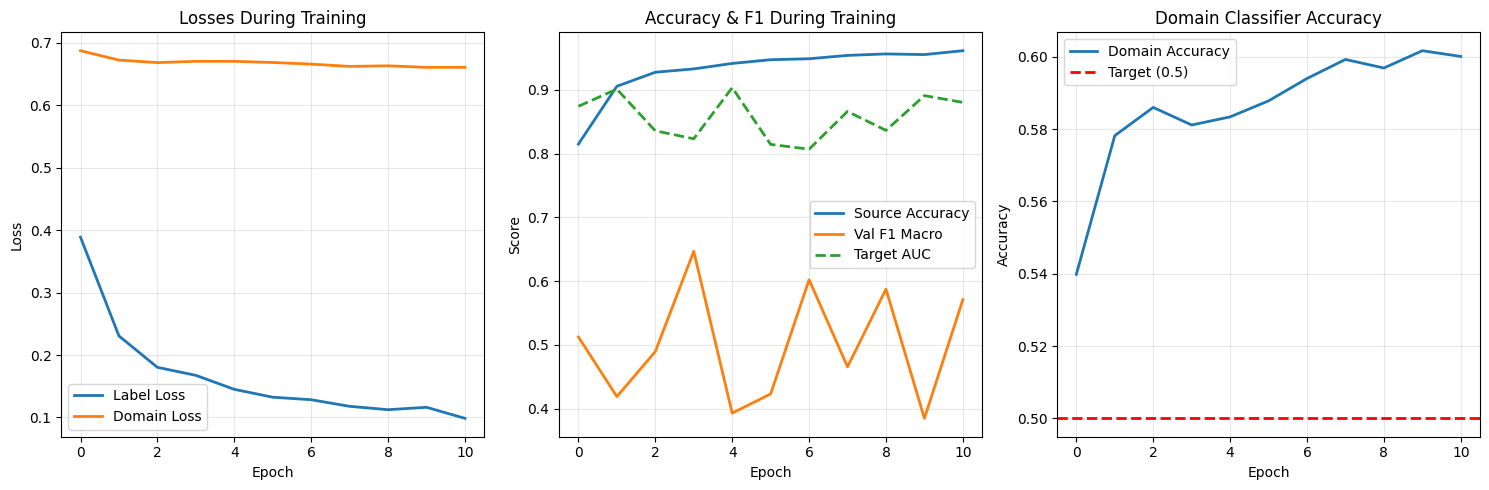


ПОЛНЫЙ ОТЧЁТ ДЛЯ λ = 0.2
Best Threshold (по F1 Macro на source val): 0.8500

                  МЕТРИКИ ДЛЯ ВСЕХ НАБОРОВ                  
------------------------------------------------------------
Dataset         Acc      Bal_Acc  F1_Macro  F1_Bin   Prec     Recall   AUC     
------------------------------------------------------------
Source Train    0.577    0.584    0.569     0.628    0.542    0.747     0.553
Source Test     0.579    0.586    0.571     0.628    0.543    0.745     0.554
Target Train    0.753    0.759    0.749     0.780    0.679    0.917     0.880
Target Test     0.758    0.765    0.755     0.784    0.684    0.918     0.880

CONFUSION MATRICES


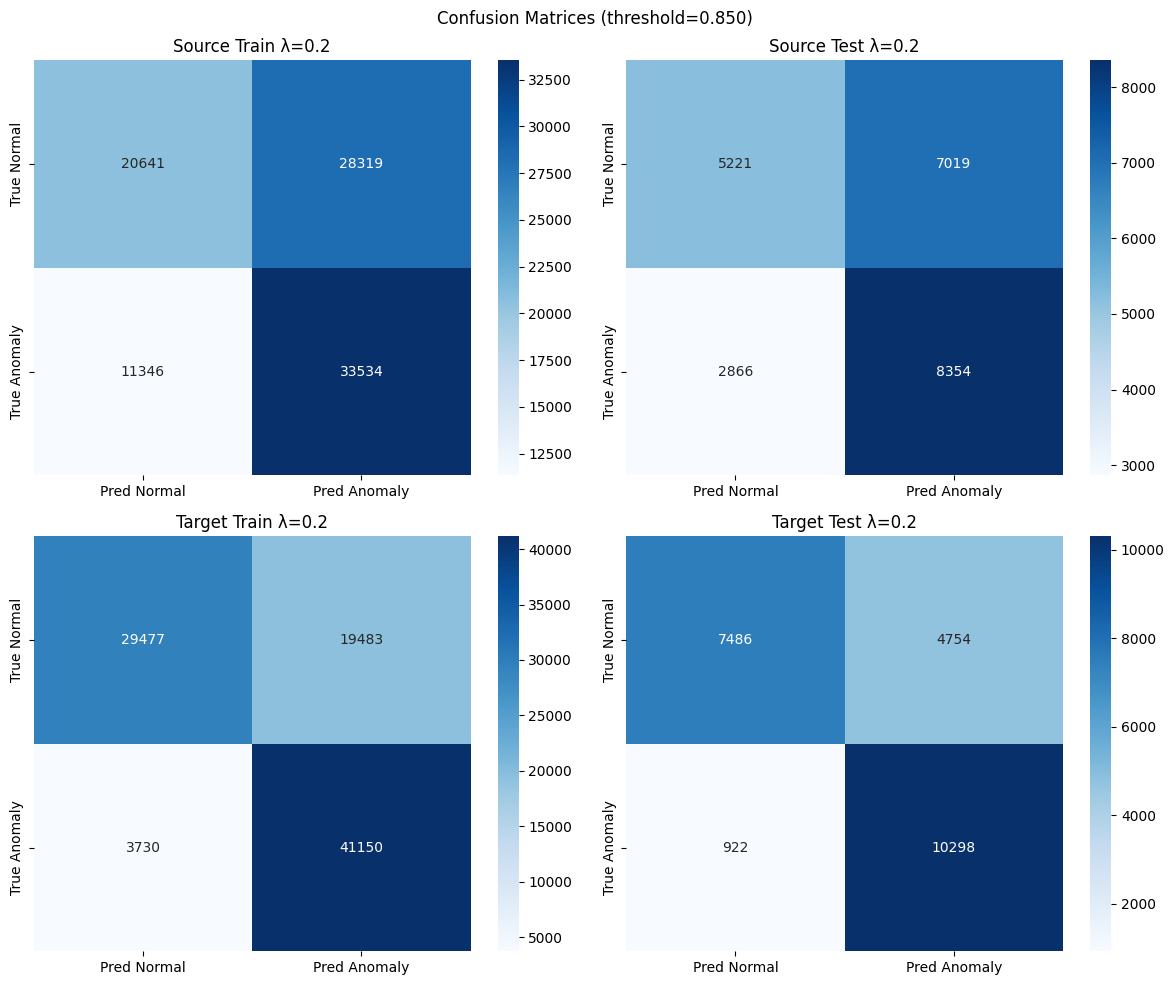


ROC CURVES


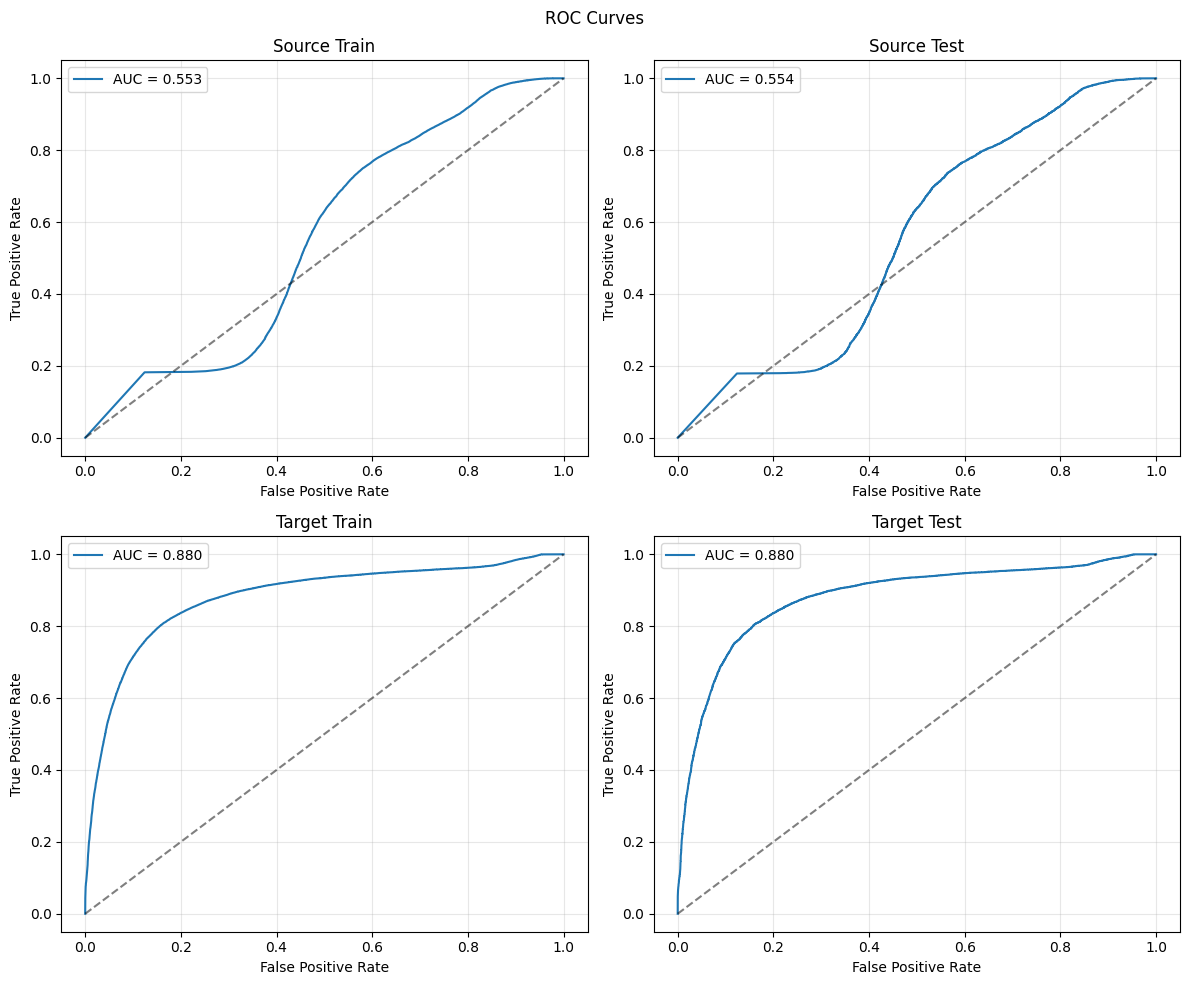


PROBABILITIES DISTRIBUTION


/var/folders/t3/4qj_4k256mxg4l2py__407l00000gn/T/ipykernel_9245/458173156.py:15: RuntimeWarning: overflow encountered in exp
  tgt_probs = 1 / (1 + np.exp(-tgt_logits))
/var/folders/t3/4qj_4k256mxg4l2py__407l00000gn/T/ipykernel_9245/458173156.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([src_normal, src_anomaly, tgt_normal, tgt_anomaly],


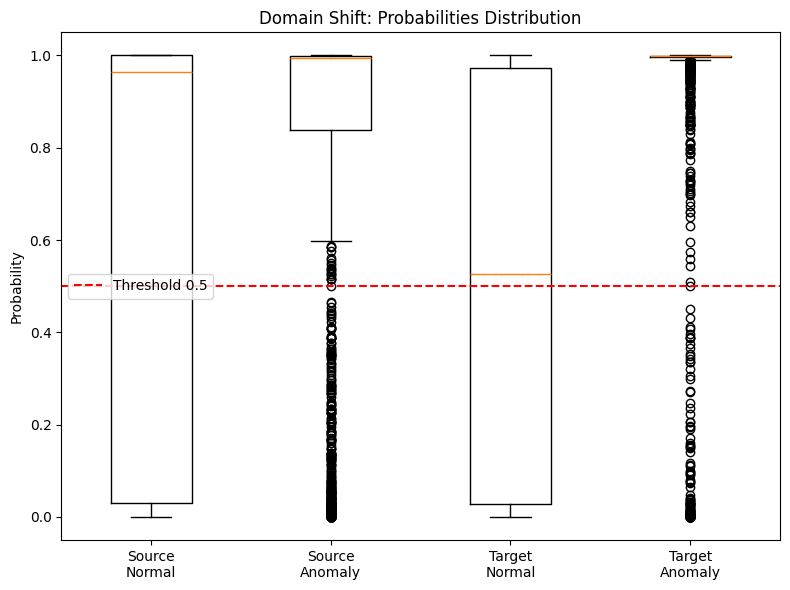


ИТОГОВОЕ СРАВНЕНИЕ λ
λ      Threshold  Target_Acc  Target_F1M   Target_AUC  Disc_Acc 
------------------------------------------------------------
0.2    0.850      0.758       0.755        0.880       0.600    
Лучший результат по F1 Macro: λ = 0.2
F1 Macro на target: 0.755
Accuracy на target: 0.758


In [6]:
# ЗАПУСК
lambda_values = [0.2]
results = []

for lambda_val in lambda_values:
    print(f"\n{'='*20} Тестируем λ = {lambda_val} {'='*20}")
    
    model = DANN(in_ch=3, emb_dim=128).to(device)
    history, best_threshold = train_dann_with_target_tracking(
        model, src_loader, tgt_loader, val_loader,
        X_src_val_cnn, y_src_val,
        X_t_test_cnn, y_t_test,  # отслеживаем target
        epochs=30, lr=1e-3, early_stopping=7, lambda_const=lambda_val
    )
    
    # График динамики обучения
    print(f"\nТРЕНИРОВОЧНЫЕ КРИВЫЕ")
    plot_training_curves(history)
    
    # Полный отчёт
    generate_full_report(model, best_threshold, lambda_val)
    
    # Сохраняем результаты для сравнения
    target_proba = model.predict_proba(X_t_test_cnn)
    target_metrics = calculate_all_metrics(y_t_test, target_proba, best_threshold)
    
    results.append({
        'lambda': lambda_val,
        'threshold': best_threshold,
        'target_metrics': target_metrics,
        'final_disc_acc': history['disc_acc'][-1]
    })

# ИТОГИ
print(f"\n{'='*60}")
print("ИТОГОВОЕ СРАВНЕНИЕ λ")
print(f"{'='*60}")
print(f"{'λ':<6} {'Threshold':<10} {'Target_Acc':<11} {'Target_F1M':<12} {'Target_AUC':<11} {'Disc_Acc':<9}")
print("-" * 60)

for r in results:
    tm = r['target_metrics']
    print(f"{r['lambda']:<6} {r['threshold']:<10.3f} {tm['accuracy']:<11.3f} "
          f"{tm['f1_macro']:<12.3f} {tm['roc_auc']:<11.3f} {r['final_disc_acc']:<9.3f}")

best_result = max(results, key=lambda x: x['target_metrics']['f1_macro'])
print(f"Лучший результат по F1 Macro: λ = {best_result['lambda']}")
print(f"F1 Macro на target: {best_result['target_metrics']['f1_macro']:.3f}")
print(f"Accuracy на target: {best_result['target_metrics']['accuracy']:.3f}")


In [2]:
class CNN1DEncoder(nn.Module):
    def __init__(self, in_ch=3, emb_dim=128, dropout=0.2):
        super().__init__()
        self.fe = nn.Sequential(
            nn.Conv1d(in_ch, 32, kernel_size=9, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),     

            nn.Conv1d(32, 64, kernel_size=7, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),     
            nn.Dropout(dropout),

            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),     
            nn.Dropout(dropout),

            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),     
        )
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.proj = nn.Linear(128, emb_dim)

    def forward(self, x_bcT):
        h = self.fe(x_bcT)              
        h = self.gap(h).squeeze(-1)     
        z = self.proj(h)                
        return z

class TaskClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 16), nn.BatchNorm1d(16), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(16, 1)  
        )
    def forward(self, x): 
        return self.net(x)

class DomainDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(128, 32), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(32, 1) 
        )
    def forward(self, features):
        return self.net(features)

class DANN(nn.Module):
    def __init__(self, in_ch=3, emb_dim=128):  
        super().__init__()
        self.feature_extractor = CNN1DEncoder(in_ch=in_ch, emb_dim=emb_dim)
        self.label_predictor = TaskClassifier()
        self.domain_classifier = DomainDiscriminator()
        self.grl = GradientReversalLayer()
        
    def forward(self, x):  
        features = self.feature_extractor(x)
        label_pred = self.label_predictor(features)
        reversed_features = self.grl(features)
        domain_pred = self.domain_classifier(reversed_features)
        return label_pred, domain_pred

    def predict_proba(self, X_cnn, batch_size=64):
        self.eval()
        X_tensor = torch.from_numpy(np.array(X_cnn)).float()
        if X_tensor.ndim != 3:
            raise ValueError("Ожидается [N, C, T] формат")
        preds = []
        with torch.no_grad():
            for i in range(0, len(X_tensor), batch_size):
                x_batch = X_tensor[i:i+batch_size].to(device)
                label_pred, _ = self(x_batch)
                preds.append(torch.sigmoid(label_pred).cpu().numpy().flatten())
        return np.concatenate(preds, 0)


==================== Тестируем λ = 0.16 ====================
Epoch 1/30 - loss: 0.4315 - accuracy: 0.7938 - disc_loss: 0.6903 - disc_acc: 0.5265 - val_f1_macro: 0.4875 - target_auc: 0.7946 - λ: 0.1600
Epoch 2/30 - loss: 0.2704 - accuracy: 0.8854 - disc_loss: 0.6821 - disc_acc: 0.5532 - val_f1_macro: 0.7801 - target_auc: 0.8167 - λ: 0.1600
Epoch 3/30 - loss: 0.2108 - accuracy: 0.9120 - disc_loss: 0.6714 - disc_acc: 0.5799 - val_f1_macro: 0.6237 - target_auc: 0.8661 - λ: 0.1600
Epoch 4/30 - loss: 0.1958 - accuracy: 0.9202 - disc_loss: 0.6696 - disc_acc: 0.5856 - val_f1_macro: 0.7702 - target_auc: 0.8173 - λ: 0.1600
Epoch 5/30 - loss: 0.1708 - accuracy: 0.9310 - disc_loss: 0.6683 - disc_acc: 0.5913 - val_f1_macro: 0.4909 - target_auc: 0.8398 - λ: 0.1600
Epoch 6/30 - loss: 0.1703 - accuracy: 0.9323 - disc_loss: 0.6689 - disc_acc: 0.5899 - val_f1_macro: 0.8364 - target_auc: 0.7873 - λ: 0.1600
Epoch 7/30 - loss: 0.1571 - accuracy: 0.9383 - disc_loss: 0.6621 - disc_acc: 0.6032 - val_f1_macro

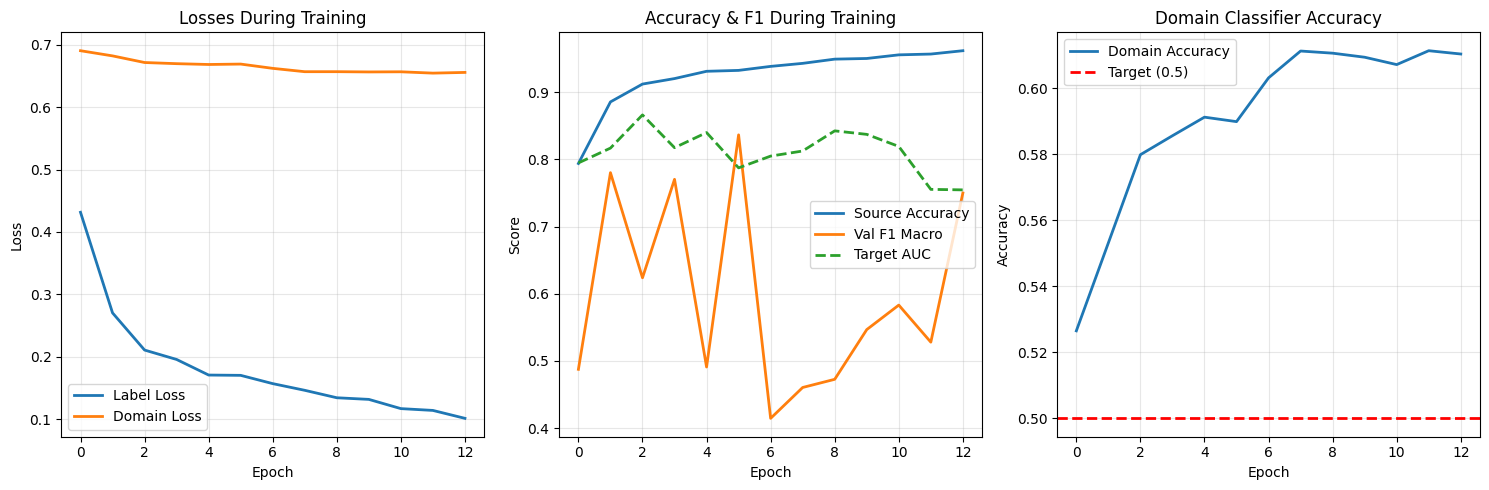


ПОЛНЫЙ ОТЧЁТ ДЛЯ λ = 0.16
Best Threshold (по F1 Macro на source val): 0.1000

                  МЕТРИКИ ДЛЯ ВСЕХ НАБОРОВ                  
------------------------------------------------------------
Dataset         Acc      Bal_Acc  F1_Macro  F1_Bin   Prec     Recall   AUC     
------------------------------------------------------------
Source Train    0.750    0.749    0.749     0.732    0.752    0.712     0.846
Source Test     0.751    0.749    0.750     0.731    0.756    0.708     0.847
Target Train    0.597    0.609    0.568     0.679    0.548    0.893     0.746
Target Test     0.599    0.612    0.571     0.681    0.550    0.896     0.755

CONFUSION MATRICES


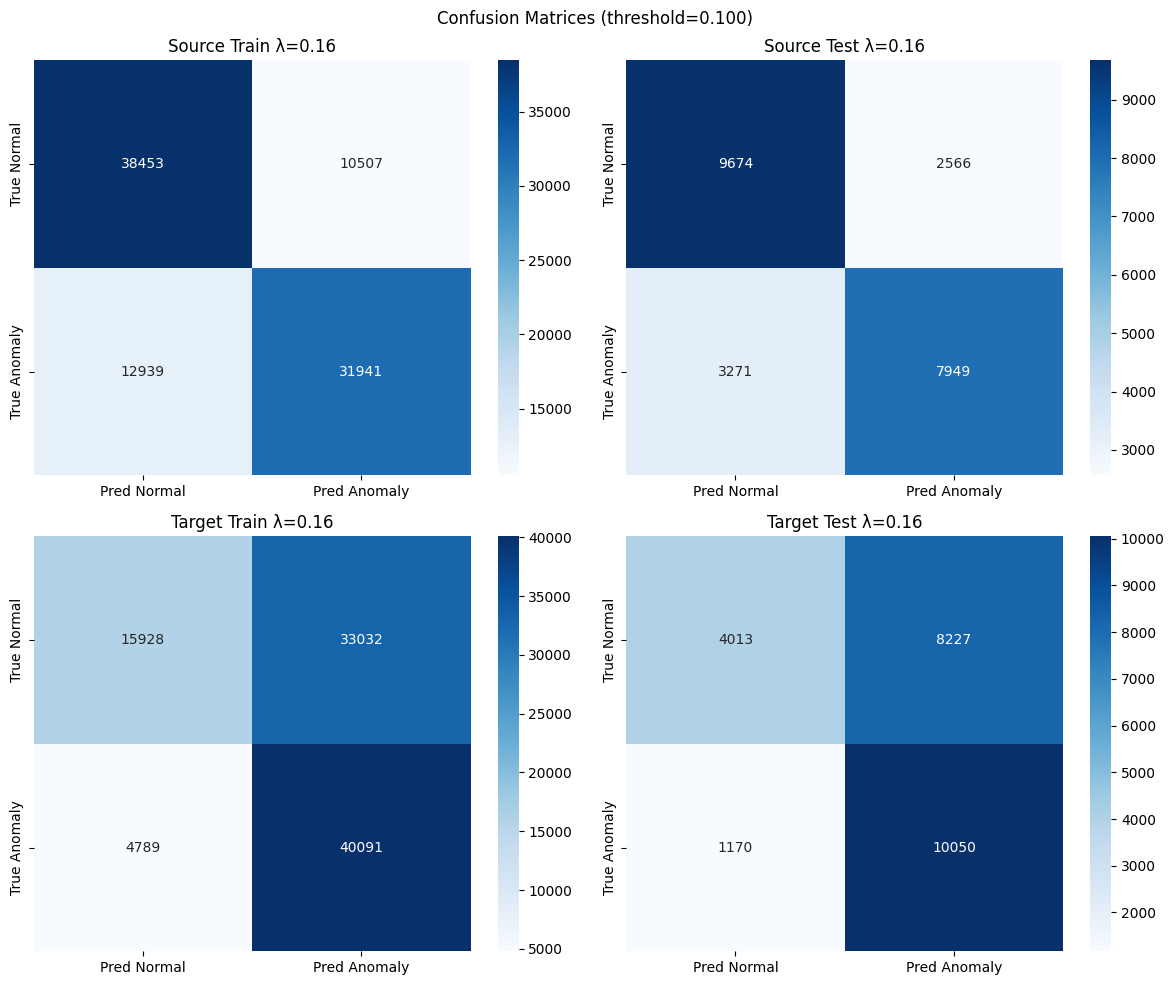


ROC CURVES


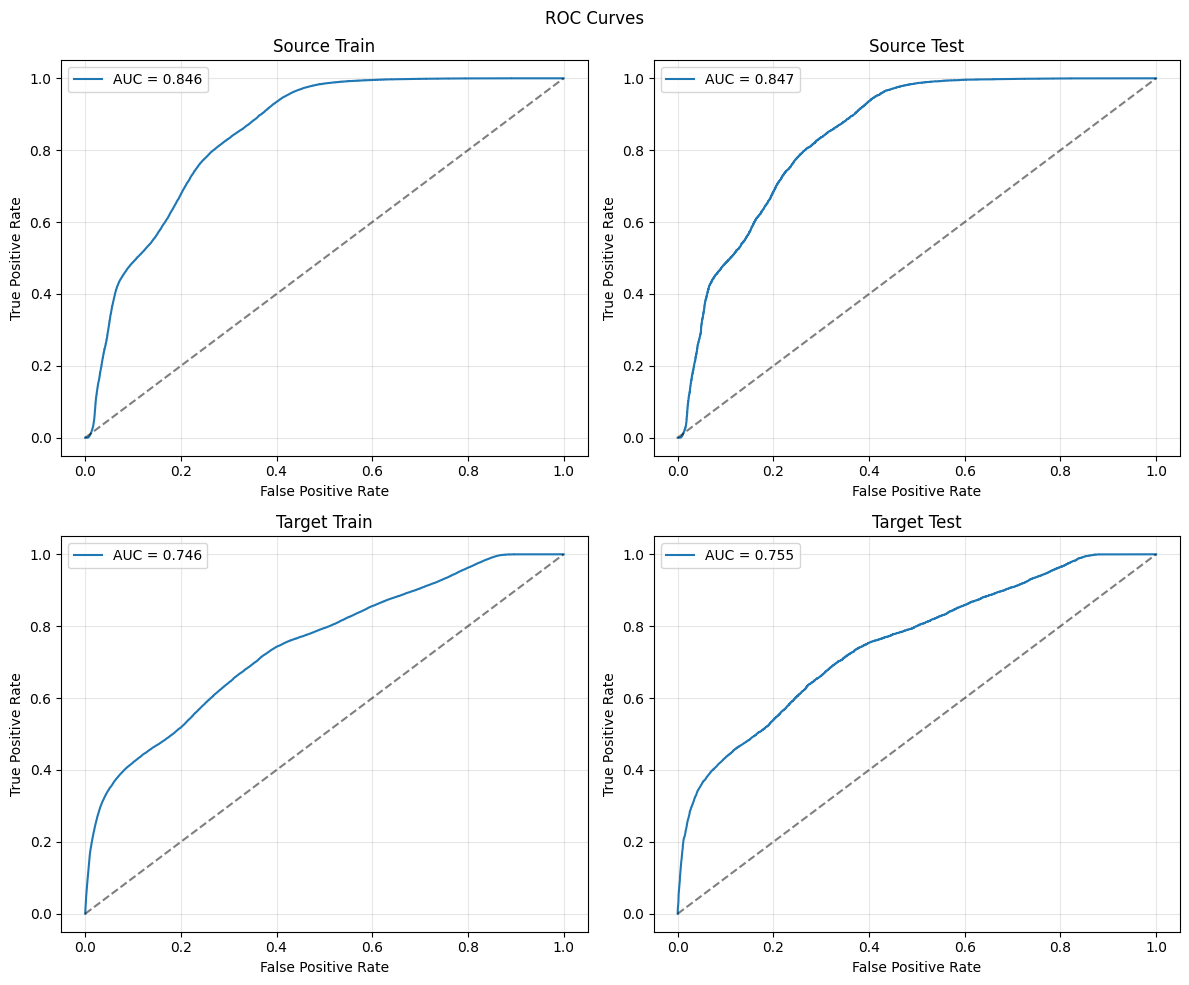


PROBABILITIES DISTRIBUTION


/var/folders/t3/4qj_4k256mxg4l2py__407l00000gn/T/ipykernel_24548/458173156.py:15: RuntimeWarning: overflow encountered in exp
  tgt_probs = 1 / (1 + np.exp(-tgt_logits))
/var/folders/t3/4qj_4k256mxg4l2py__407l00000gn/T/ipykernel_24548/458173156.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([src_normal, src_anomaly, tgt_normal, tgt_anomaly],


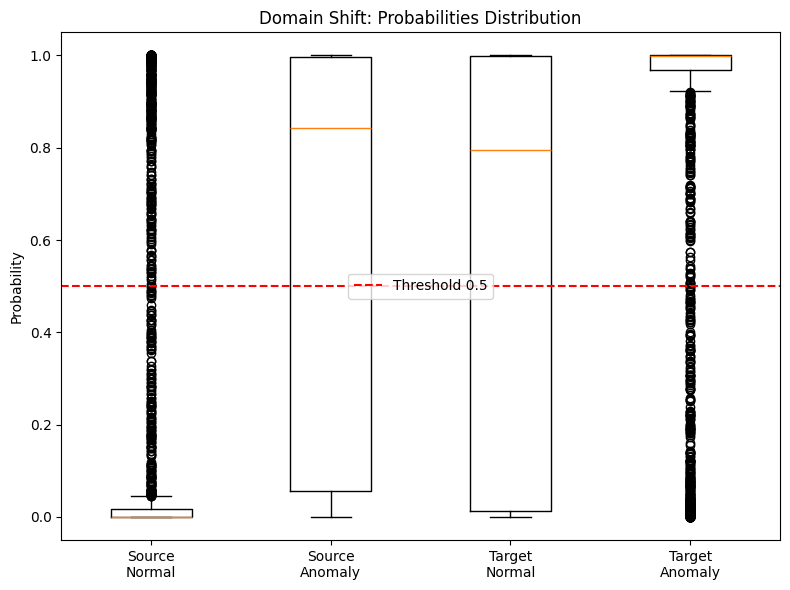


ИТОГОВОЕ СРАВНЕНИЕ λ
λ      Threshold  Target_Acc  Target_F1M   Target_AUC  Disc_Acc 
------------------------------------------------------------
0.16   0.100      0.599       0.571        0.755       0.610    
Лучший результат по F1 Macro: λ = 0.16
F1 Macro на target: 0.571
Accuracy на target: 0.599


In [7]:
# ОБУЧЕНИЕ
def train_dann_with_target_tracking(model, src_loader, tgt_loader, val_loader, X_val_cnn, y_val,
                                   X_target_cnn, y_target,
                                   epochs=50, lr=1e-4, early_stopping=10, lambda_const=0.15):
    # Обучение с отслеживанием метрик на target
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion_label = nn.BCEWithLogitsLoss()
    criterion_domain = nn.BCEWithLogitsLoss()
    
    best_val_f1, patience = 0, 0
    best_state = None

    history = {
        "loss": [], "accuracy": [], "disc_loss": [], "disc_acc": [],
        "val_f1": [], "target_auc": [], "target_f1_macro": [], "λ": []
    }

    for epoch in range(epochs):
        model.train()
        λ = lambda_const
        model.grl.set_alpha(λ)
        
        epoch_losses, epoch_accs = [], []
        epoch_disc_losses, epoch_disc_accs = [], []
        
        min_len = min(len(src_loader), len(tgt_loader))
        src_iter, tgt_iter = iter(src_loader), iter(tgt_loader)
        
        for batch_idx in range(min_len):
            try:
                src_data, src_labels = next(src_iter)
                tgt_data = next(tgt_iter)[0]
            except StopIteration:
                break
                
            batch_size = min(src_data.size(0), tgt_data.size(0))
            src_data = src_data[:batch_size].to(device)
            src_labels = src_labels[:batch_size].to(device)
            tgt_data = tgt_data[:batch_size].to(device)
            
            optimizer.zero_grad()
            
            src_label_pred, src_domain_pred = model(src_data)
            _, tgt_domain_pred = model(tgt_data)
            
            loss_label = criterion_label(src_label_pred, src_labels)
            
            domain_labels = torch.cat([
                torch.zeros(batch_size, 1, device=device),
                torch.ones(batch_size, 1, device=device)
            ])
            
            domain_preds = torch.cat([src_domain_pred, tgt_domain_pred])
            loss_domain = criterion_domain(domain_preds, domain_labels)
            
            total_loss = loss_label + λ * loss_domain
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            label_acc = accuracy_from_logits(src_label_pred, src_labels)
            domain_acc = accuracy_from_logits(domain_preds, domain_labels)
            
            epoch_losses.append(loss_label.item())
            epoch_accs.append(label_acc)
            epoch_disc_losses.append(loss_domain.item())
            epoch_disc_accs.append(domain_acc)
        
        # Валидация на source
        model.eval()
        val_proba = model.predict_proba(X_val_cnn)         
        best_thresh, val_f1_macro = find_best_threshold_f1_macro(y_val, val_proba)  
        
        # Отслеживание target метрик 
        target_proba = model.predict_proba(X_target_cnn)
        target_auc = roc_auc_score(y_target, target_proba)
        target_f1_macro = f1_score(y_target, (target_proba > 0.5).astype(int), average='macro')

        # Early stopping по source
        if val_f1_macro > best_val_f1:
            best_val_f1, best_state = val_f1_macro, model.state_dict().copy()
            patience = 0
        else:
            patience += 1

        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {np.mean(epoch_losses):.4f} - accuracy: {np.mean(epoch_accs):.4f} - "
              f"disc_loss: {np.mean(epoch_disc_losses):.4f} - disc_acc: {np.mean(epoch_disc_accs):.4f} - "
              f"val_f1_macro: {val_f1_macro:.4f} - target_auc: {target_auc:.4f} - λ: {λ:.4f}")

        history["loss"].append(np.mean(epoch_losses))
        history["accuracy"].append(np.mean(epoch_accs))
        history["disc_loss"].append(np.mean(epoch_disc_losses))
        history["disc_acc"].append(np.mean(epoch_disc_accs))
        history["val_f1"].append(val_f1_macro)
        history["target_auc"].append(target_auc)
        history["target_f1_macro"].append(target_f1_macro)
        history["λ"].append(λ)

        if patience >= early_stopping:
            print("Early stopping.")
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return history, best_thresh

# ФУНКЦИЯ ОТЧЁТА 
def generate_full_report(model, threshold, lambda_val):    
    # Определяем наборы данных
    datasets = [
        (X_src_train_cnn, y_src_train, "Source Train"),
        (X_src_val_cnn, y_src_val, "Source Test"), 
        (X_t_train_cnn, y_t_train, "Target Train"),
        (X_t_test_cnn, y_t_test, "Target Test")
    ]
    
    print(f"\n{'='*60}")
    print(f"ПОЛНЫЙ ОТЧЁТ ДЛЯ λ = {lambda_val}")
    print(f"Best Threshold (по F1 Macro на source val): {threshold:.4f}")
    print(f"{'='*60}")
    
    # 1. Метрики для всех 4 наборов с единым порогом
    print(f"\n{'МЕТРИКИ ДЛЯ ВСЕХ НАБОРОВ':^60}")
    print("-" * 60)
    print(f"{'Dataset':<15} {'Acc':<8} {'Bal_Acc':<8} {'F1_Macro':<9} {'F1_Bin':<8} {'Prec':<8} {'Recall':<8} {'AUC':<8}")
    print("-" * 60)
    
    for X, y, title in datasets:
        y_proba = model.predict_proba(X, batch_size=64)
        metrics = calculate_all_metrics(y, y_proba, threshold)
        
        print(f"{title:<15} {metrics['accuracy']:.3f}    {metrics['balanced_accuracy']:.3f}    "
              f"{metrics['f1_macro']:.3f}     {metrics['f1_binary']:.3f}    {metrics['precision']:.3f}    "
              f"{metrics['recall']:.3f}     {metrics['roc_auc']:.3f}")
    
    # 2. Четыре confusion matrix
    print(f"\n{'CONFUSION MATRICES'}")
    plot_four_confusion_matrices(model, datasets, threshold, f"λ={lambda_val}")
    
    # 3. Четыре ROC кривые
    print(f"\n{'ROC CURVES'}")
    plot_four_roc_curves(model, datasets)
    
    # 4. Boxplot вероятностей
    print(f"\n{'PROBABILITIES DISTRIBUTION'}")
    visualize_probabilities_boxplot(model, X_src_val_cnn, y_src_val, X_t_test_cnn, y_t_test, 
                                   device, batch_size=256, sample_size=5000)

# ЗАПУСК
lambda_values = [0.16]
results = []

for lambda_val in lambda_values:
    print(f"\n{'='*20} Тестируем λ = {lambda_val} {'='*20}")
    
    model = DANN(in_ch=3, emb_dim=128).to(device)
    history, best_threshold = train_dann_with_target_tracking(
        model, src_loader, tgt_loader, val_loader,
        X_src_val_cnn, y_src_val,
        X_t_test_cnn, y_t_test,  # отслеживаем target
        epochs=30, lr=1e-3, early_stopping=7, lambda_const=lambda_val
    )
    
    # График динамики обучения
    print(f"\nТРЕНИРОВОЧНЫЕ КРИВЫЕ")
    plot_training_curves(history)
    
    # Полный отчёт
    generate_full_report(model, best_threshold, lambda_val)
    
    # Сохраняем результаты для сравнения
    target_proba = model.predict_proba(X_t_test_cnn)
    target_metrics = calculate_all_metrics(y_t_test, target_proba, best_threshold)
    
    results.append({
        'lambda': lambda_val,
        'threshold': best_threshold,
        'target_metrics': target_metrics,
        'final_disc_acc': history['disc_acc'][-1]
    })

# ИТОГИ
print(f"\n{'='*60}")
print("ИТОГОВОЕ СРАВНЕНИЕ λ")
print(f"{'='*60}")
print(f"{'λ':<6} {'Threshold':<10} {'Target_Acc':<11} {'Target_F1M':<12} {'Target_AUC':<11} {'Disc_Acc':<9}")
print("-" * 60)

for r in results:
    tm = r['target_metrics']
    print(f"{r['lambda']:<6} {r['threshold']:<10.3f} {tm['accuracy']:<11.3f} "
          f"{tm['f1_macro']:<12.3f} {tm['roc_auc']:<11.3f} {r['final_disc_acc']:<9.3f}")

best_result = max(results, key=lambda x: x['target_metrics']['f1_macro'])
print(f"Лучший результат по F1 Macro: λ = {best_result['lambda']}")
print(f"F1 Macro на target: {best_result['target_metrics']['f1_macro']:.3f}")
print(f"Accuracy на target: {best_result['target_metrics']['accuracy']:.3f}")